When running active learning it's usually a good idea to start off "simple" and make the system/structures gradually more complicated.

For getting a model which predicts conformers accurately, we may take the following approach:

* first train a potential at slightly above room temperature with NVT MD

* continue training a second potential using CREST metadynamics

* generate conformers with the previous model and also train to those

## Initial imports

In [1]:
import scm.plams as plams
import scm.params as params
from scm.simple_active_learning import SimpleActiveLearningJob
import matplotlib.pyplot as plt
from scm.external_engines.core import interface_is_installed
import os
import numpy as np
from typing import List
from scm.conformers import ConformersJob
from scm.conformers.plams.plot import plot_conformers

assert interface_is_installed(
    "m3gnet"
), "You must install the m3gnet backend before following this tutorial!"

In [2]:
plams.init()

PLAMS working folder: /home/hellstrom/testnb/conformers/plams_workdir


## Create the initial structure

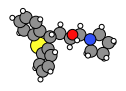

In [3]:
molecule = plams.from_smiles("OC(CC1c2ccccc2Sc2ccccc21)CN1CCCC1", forcefield="uff")
molecule.delete_all_bonds()
for at in molecule:
    at.properties = plams.Settings()
plams.plot_molecule(molecule)
starting_structure = molecule

## Reference engine settings

In [4]:
fast_ref_s = plams.Settings()
fast_ref_s.input.DFTB.Model = "GFN1-xTB"

slow_ref_s = plams.Settings()
slow_ref_s.input.ADF.Basis.Type = "TZP"
slow_ref_s.input.ADF.Basis.Core = "None"
slow_ref_s.input.ADF.XC.Hybrid = "B3LYP"
slow_ref_s.input.ADF.XC.DISPERSION = "GRIMME3 BJDAMP"

Change to slow_ref_s to train to B3LYP-D3(BJ) instead:

In [5]:
ref_s = fast_ref_s.copy()
# ref_s = slow_ref_s.copy()
perform_expensive_tests = ref_s == fast_ref_s

## Problem statement: Generate a few conformers with M3GNet-UP-2022 and Score with reference method

In [6]:
m3gnet_up_s = plams.Settings()
m3gnet_up_s.input.MLPotential.Model = "M3GNet-UP-2022"

In [7]:
generate_conformers_m3gnet_up_job = ConformersJob(
    name="generate_conformers_m3gnet_up", molecule=starting_structure
)
generate_conformers_m3gnet_up_job.settings.input.ams.Task = "Generate"
generate_conformers_m3gnet_up_job.settings.input.ams.Generator.Method = "RDKit"
generate_conformers_m3gnet_up_job.settings.input.ams.Generator.RDKit.InitialNConformers = 40
# generate_conformers_m3gnet_up_job.settings += crest_al_job.results.get_production_engine_settings()
generate_conformers_m3gnet_up_job.settings += m3gnet_up_s
# generate_conformers_m3gnet_up_job.settings.runscript.nproc = 1  # run in serial, useful if you run out of memory when running M3GNet on the GPU

generate_conformers_m3gnet_up_job.run();

[13.03|09:15:30] JOB generate_conformers_m3gnet_up STARTED
[13.03|09:15:30] JOB generate_conformers_m3gnet_up RUNNING
[13.03|09:17:10] JOB generate_conformers_m3gnet_up FINISHED
[13.03|09:17:10] JOB generate_conformers_m3gnet_up SUCCESSFUL


Show the 4 most stable conformers with M3GNet-UP-2022:

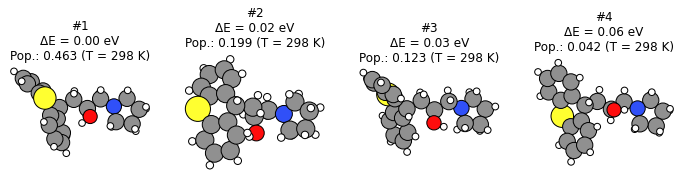

In [8]:
plot_conformers(generate_conformers_m3gnet_up_job, 4, unit="eV");

Score the generated conformers with the reference method:

In [9]:
score_conformers_ref_job = ConformersJob(name="score_conformers_ref")
score_conformers_ref_job.settings.input.ams.Task = "Score"
score_conformers_ref_job.settings.input.ams.InputConformersSet = (
    generate_conformers_m3gnet_up_job.results.rkfpath()
)
score_conformers_ref_job.settings.input += ref_s.input
score_conformers_ref_job.run();

[13.03|09:17:10] JOB score_conformers_ref STARTED
[13.03|09:17:10] JOB score_conformers_ref RUNNING
[13.03|09:17:16] JOB score_conformers_ref FINISHED
[13.03|09:17:16] JOB score_conformers_ref SUCCESSFUL


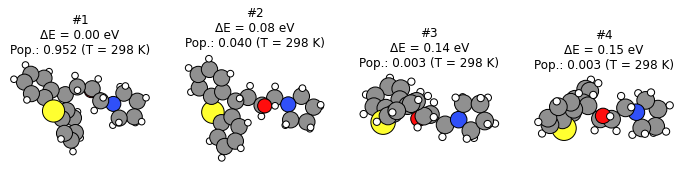

In [10]:
plot_conformers(score_conformers_ref_job, 4, unit="eV");

Here we can see that the ordering of conformers at the reference level is completely different compared to M3GNet-UP-2022.

The Score job reorders the conformers. To compare the energies more precisely, we can use the minimum pairwise RMSD (which should be 0) to identify how the order of conformers change:

In [11]:
def get_pairwise_rmsds(
    molecules_ref: List[plams.Molecule], molecules_pred: List[plams.Molecule]
) -> np.ndarray:
    """Returns a len(molecules_ref)*len(molecules_pred) numpy array with pairwise rmsds (in angstrom) between the structures"""
    rmsds = np.zeros((len(molecules_ref), len(molecules_pred)))

    for i, ref_mol in enumerate(molecules_ref):
        for j, pred_mol in enumerate(molecules_pred):
            rmsds[i, j] = plams.Molecule.rmsd(ref_mol, pred_mol)

    return rmsds


def get_reordering(rmsds: np.ndarray) -> np.ndarray:
    """
    rmsds: numpy array with shape len(molecules_ref)*len(molecules_pred)

    Returns a len(molecules_ref) integer numpy array.
    The first element is the index (0-based) in molecules_pred corresponding to the first reference molecule, etc.
    """
    rmsds = get_pairwise_rmsds(molecules_ref, molecules_pred)
    reordering = np.argmin(rmsds, axis=1)
    return reordering


def print_reordering_table(molecules_ref, molecules_pred, energies_ref, energies_pred, ax=None):
    """This functions prints the reordering table including relative energies. It also plots the predicted relative energies versus the reference relative energies"""
    print(f"Ref_i  Pred_i RMSD Ref_dE  Pred_dE")
    x, y = [], []
    rmsds = get_pairwise_rmsds(molecules_ref, molecules_pred)
    reordering = get_reordering(rmsds)
    rmsd_threshold = 0.7  # angstrom, for printing/plotting points
    for ref_i, pred_i in enumerate(reordering):
        rmsd = rmsds[ref_i, pred_i]
        ref_relative_e = energies_ref[ref_i]
        pred_relative_e = energies_pred[pred_i] - energies_pred[reordering[0]]
        if rmsd <= rmsd_threshold:
            print(
                f"{ref_i:6d} {pred_i:6d} {rmsd:4.1f} {ref_relative_e:7.2f} {pred_relative_e:7.2f}"
            )
            x.append(ref_relative_e)
            y.append(pred_relative_e)
        else:
            print(f"{ref_i:6d} {pred_i:6d} rmsd > {rmsd_threshold:.1f} ang.")

    if ax is None:
        _, ax = plt.subplots()

    m, M = np.min([np.min(x), np.min(y)]), np.max([np.max(x), np.max(y)])
    ax.plot(x, y, ".")
    ax.plot([m, M], [m, M], "-")
    ax.set_xlabel("ref. deltaE (eV)")
    ax.set_ylabel("pred. deltaE (eV)")

    return ax

In the below table the energies are given with respect to the structure that had the lowest reference energy. This is thus different compared to the first image above, where the predicted (m3gnet-up-2022) relative energies were given to predicted lowest energy conformer.

Ref_i  Pred_i RMSD Ref_dE  Pred_dE
     0      5  0.0    0.00    0.00
     1      3  0.0    0.08   -0.01
     2     19  0.0    0.14    0.07
     3     20  0.0    0.15    0.08
     4      7  0.0    0.18    0.02
     5      2  0.0    0.21   -0.04
     6      6  0.0    0.22    0.01
     7     18  0.0    0.26    0.07
     8     15  0.0    0.30    0.05
     9      0  0.0    0.31   -0.07
    10     17  0.0    0.31    0.07
    11     14  0.0    0.35    0.04
    12     23  0.0    0.36    0.12
    13     21  0.0    0.37    0.08
    14     22  0.0    0.37    0.09
    15      4  0.0    0.39   -0.01
    16     10  0.0    0.39    0.02
    17     11  0.0    0.42    0.03
    18      9  0.0    0.48    0.02
    19     16  0.0    0.50    0.06
    20     12  0.0    0.56    0.04
    21     24  0.0    0.60    0.17
    22      8  0.0    0.68    0.02
    23     13  0.0    0.75    0.04
    24      1  0.0    0.97   -0.05


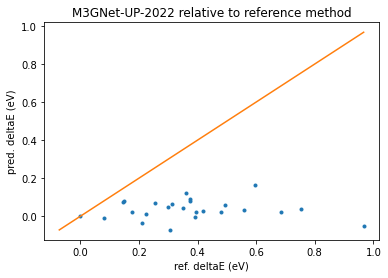

In [12]:
molecules_ref = score_conformers_ref_job.results.get_conformers()
energies_ref = score_conformers_ref_job.results.get_relative_energies(unit="eV")
molecules_pred = generate_conformers_m3gnet_up_job.results.get_conformers()
energies_pred = generate_conformers_m3gnet_up_job.results.get_relative_energies(unit="ev")
ax = print_reordering_table(molecules_ref, molecules_pred, energies_ref, energies_pred)
ax.set_title("M3GNet-UP-2022 relative to reference method");

Here we see that there is no correlation between the relative stabilities calculated with M3GNet-UP-2022 and the reference method.

Example: The most stable conformer with the reference method (Ref_i=0) corresponds to the tenth most stable conformer with M3GNet-UP-2022 (Pred_i=10)

Example 2: The second most stable conformer with the reference method (Ref_i=1) should be 0.08 eV *less* stable than the ref_i=0 conformer, but with M3GNet-UP-2022 method it is actually 0.01 eV *more* stable!

## Optimize a few conformers for initial reference data

Conformers are local minima on the potential energy surface. The Active Learning MD will sample off-equilibrium structures. So let's make sure that there are at least some local minima in the training set by optimizing some of the generated conformers.

Here, we loop over the conformers and run GeometryOptimization jobs. This produces output files in the normal AMS format that can easily be imported into ParAMS

In [13]:
max_N = min(6, len(molecules_pred))  # at most 6 optimizations
opt_s = plams.Settings()
opt_s.input.ams.Task = "GeometryOptimization"
opt_s.input.ams.GeometryOptimization.Convergence.Quality = "Basic"
opt_jobs = [
    plams.AMSJob(settings=opt_s + ref_s, name=f"opt_{i}", molecule=mol)
    for i, mol in enumerate(molecules_pred[:max_N])
]
for opt_job in opt_jobs:
    opt_job.run()

[13.03|09:17:18] JOB opt_0 STARTED
[13.03|09:17:18] JOB opt_0 RUNNING
[13.03|09:17:28] JOB opt_0 FINISHED
[13.03|09:17:28] JOB opt_0 SUCCESSFUL
[13.03|09:17:28] JOB opt_1 STARTED
[13.03|09:17:28] JOB opt_1 RUNNING
[13.03|09:17:41] JOB opt_1 FINISHED
[13.03|09:17:41] JOB opt_1 SUCCESSFUL
[13.03|09:17:41] JOB opt_2 STARTED
[13.03|09:17:41] JOB opt_2 RUNNING
[13.03|09:17:47] JOB opt_2 FINISHED
[13.03|09:17:47] JOB opt_2 SUCCESSFUL
[13.03|09:17:47] JOB opt_3 STARTED
[13.03|09:17:47] JOB opt_3 RUNNING
[13.03|09:17:54] JOB opt_3 FINISHED
[13.03|09:17:55] JOB opt_3 SUCCESSFUL
[13.03|09:17:55] JOB opt_4 STARTED
[13.03|09:17:55] JOB opt_4 RUNNING
[13.03|09:18:08] JOB opt_4 FINISHED
[13.03|09:18:08] JOB opt_4 SUCCESSFUL
[13.03|09:18:08] JOB opt_5 STARTED
[13.03|09:18:08] JOB opt_5 RUNNING
[13.03|09:18:14] JOB opt_5 FINISHED
[13.03|09:18:14] JOB opt_5 SUCCESSFUL


Now import the data into a ParAMS results importer and store in the directory ``my_initial_reference_data``:

In [14]:
yaml_dir = os.path.abspath("my_initial_reference_data")
ri = params.ResultsImporter(settings={"units": {"energy": "eV", "forces": "eV/angstrom"}})

for opt_job in opt_jobs:
    ri.add_singlejob(opt_job, properties=["energy", "forces"], task="SinglePoint")

ri.store(yaml_dir, backup=False)

['/home/hellstrom/testnb/conformers/my_initial_reference_data/job_collection.yaml',
 '/home/hellstrom/testnb/conformers/my_initial_reference_data/results_importer_settings.yaml',
 '/home/hellstrom/testnb/conformers/my_initial_reference_data/training_set.yaml']

## Simple Active Learning setup


### Molecular dynamics settings (temperature ramp)

In [15]:
nvt_md_s = plams.AMSNVTJob(
    nsteps=20000,
    timestep=0.5,
    temperature=(270, 350, 350),
    tau=100,
    thermostat="Berendsen",
).settings

### ParAMS machine learning settings

In [16]:
ml_s = plams.Settings()
ml_s.input.ams.MachineLearning.Backend = "M3GNet"
ml_s.input.ams.MachineLearning.CommitteeSize = 1
ml_s.input.ams.MachineLearning.M3GNet.Model = "UniversalPotential"
ml_s.input.ams.MachineLearning.MaxEpochs = 200

### Active learning settings

Conformer search of a single molecule is quite simple, so we can expect the ML method to perform quite well. We therefore decrease the success criteria thresholds a bit compared to the default values, to ensure that we get accurate results.

Since we will immediately continue with another active learning loop, we disable the "RerunSimulation" as we are not interested in the MD simulation per se.

In [17]:
al_s = plams.Settings()
al_s.input.ams.ActiveLearning.Steps.Type = "Geometric"
al_s.input.ams.ActiveLearning.Steps.Geometric.Start = 10
al_s.input.ams.ActiveLearning.Steps.Geometric.NumSteps = 8
al_s.input.ams.ActiveLearning.InitialReferenceData.Load.Directory = yaml_dir
al_s.input.ams.ActiveLearning.InitialReferenceData.Generate.M3GNetShortMD.Enabled = "Yes"
al_s.input.ams.ActiveLearning.SuccessCriteria.Energy.Relative = 0.002
al_s.input.ams.ActiveLearning.SuccessCriteria.Forces.MaxDeviationForZeroForce = 0.30
al_s.input.ams.ActiveLearning.AtEnd.RerunSimulation = "No"

### Initial structure

Let's start with the lowest-energy conformer according to the reference method:

In [18]:
starting_structure_al = molecules_ref[0]

# The bonds are not used, so delete them to make the input file less confusing:
starting_structure_al.delete_all_bonds()

### Complete job

In [19]:
settings = ref_s + nvt_md_s + ml_s + al_s
job = SimpleActiveLearningJob(settings=settings, molecule=starting_structure_al, name="sal")
print(job.get_input())

ActiveLearning
  AtEnd
    RerunSimulation False
  End
  InitialReferenceData
    Generate
      M3GNetShortMD
        Enabled True
      End
    End
    Load
      Directory /home/hellstrom/testnb/conformers/my_initial_reference_data
    End
  End
  Steps
    Geometric
      NumSteps 8
      Start 10
    End
    Type Geometric
  End
  SuccessCriteria
    Energy
      Relative 0.002
    End
    Forces
      MaxDeviationForZeroForce 0.3
    End
  End
End
MachineLearning
  Backend M3GNet
  CommitteeSize 1
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 200
End
MolecularDynamics
  BinLog
    DipoleMoment False
    PressureTensor False
    Time False
  End
  CalcPressure False
  Checkpoint
    Frequency 1000000
  End
  InitialVelocities
    Temperature 270.0
    Type Random
  End
  NSteps 20000
  Thermostat
    Duration 10000 10000
    Tau 100.0
    Temperature 270.0 350.0 350.0
    Type Berendsen
  End
  TimeStep 0.5
  Trajectory
    SamplingFreq 100
    WriteBonds True
    WriteC

### Run the simple active learning job

In [20]:
job.run(watch=True);

[13.03|09:18:15] JOB sal STARTED
[13.03|09:18:15] JOB sal RUNNING
[13.03|09:18:17] Simple Active Learning 2024.101,  Nodes: 1, Procs: 64
[13.03|09:18:21] Composition of main system: C20H23NOS
[13.03|09:18:21] All REFERENCE calculations will be performed with the following DFTB engine:
[13.03|09:18:21]
Engine dftb
  model GFN1-xTB
EndEngine


[13.03|09:18:21] The following are the settings for the to-be-trained MACHINE LEARNING model:
[13.03|09:18:21]
MachineLearning
  Backend M3GNet
  CommitteeSize 1
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 200
End

ParallelLevels
End

[13.03|09:18:21] A single model will be trained (no committee).
[13.03|09:18:21] The ACTIVE LEARNING loop will contain 8 steps, using the following schema:
[13.03|09:18:21]    Active Learning Step   1:       10 MD Steps (cumulative:       10)
[13.03|09:18:21]    Active Learning Step   2:       19 MD Steps (cumulative:       29)
[13.03|09:18:21]    Active Learning Step   3:       58 MD Steps (cumulative:   

### Final structure from MD simulation


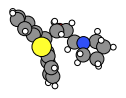

In [21]:
new_structure = job.results.get_main_molecule()
plams.plot_molecule(new_structure, rotation="-5x,5y,0z")

## Second active learning job: CREST metadynamics

Here we set Steps.Type = "Linear" to run reference calculations every 2000 MD steps.

In [22]:
nsteps = 20000

crest_md_s = plams.Settings()
crest_md_s.input.ams.MolecularDynamics.CRESTMTD.Height = 0.138
crest_md_s.input.ams.MolecularDynamics.CRESTMTD.NGaussiansMax = 50
crest_md_s.input.ams.MolecularDynamics.CRESTMTD.NSteps = 200
crest_md_s.input.ams.MolecularDynamics.CRESTMTD.Width = 0.62

crest_complete_md_s = plams.AMSMDJob(
    molecule=new_structure,
    nsteps=nsteps,
    settings=crest_md_s,
    tau=10,  # small time constant
    thermostat="NHC",
    temperature=300,
    timestep=0.5,
    samplingfreq=20,
).settings

In [23]:
# job = SimpleActiveLearningJob.load_external(plams.config.default_jobmanager.workdir + "/sal.002")
crest_ml_s = ml_s.copy()
crest_ml_s.input.ams.MachineLearning.LoadModel = job.results.get_params_results_directory()
crest_ml_s.input.ams.MachineLearning.Target.Forces.MAE = 0.04
crest_ml_s.input.ams.MachineLearning.MaxEpochs = 200

In [24]:
crest_al_s = plams.Settings()

crest_al_s.input.ams.ActiveLearning.Steps.Type = "Linear"
crest_al_s.input.ams.ActiveLearning.Steps.Linear.Start = 500
crest_al_s.input.ams.ActiveLearning.Steps.Linear.StepSize = 2000
crest_al_s.input.ams.ActiveLearning.InitialReferenceData.Load.FromPreviousModel = "Yes"

crest_al_s.input.ams.ActiveLearning.SuccessCriteria.Energy.Relative = 0.002
crest_al_s.input.ams.ActiveLearning.SuccessCriteria.Energy.Total = 0.010
# because we do not set Normalization, the above Energy criteria are energies per atom
# crest_al_s.input.ams.ActiveLearning.SuccessCriteria.Energy.Normalization =

crest_al_s.input.ams.ActiveLearning.SuccessCriteria.Forces.MaxDeviationForZeroForce = 0.30

crest_al_s.input.ams.ActiveLearning.AtEnd.RerunSimulation = "No"
crest_al_s.input.ams.ActiveLearning.MaxReferenceCalculationsPerAttempt = 3

In [25]:
crest_al_job = SimpleActiveLearningJob(
    name="crest_al",
    settings=ref_s + crest_complete_md_s + crest_ml_s + crest_al_s,
    molecule=new_structure,
)
crest_al_job.run(watch=True);

[13.03|10:33:13] JOB crest_al STARTED
[13.03|10:33:13] JOB crest_al RUNNING
[13.03|10:33:16] Simple Active Learning 2024.101,  Nodes: 1, Procs: 64
[13.03|10:33:19] Composition of main system: C20H23NOS
[13.03|10:33:19] All REFERENCE calculations will be performed with the following DFTB engine:
[13.03|10:33:19]
Engine dftb
  model GFN1-xTB
EndEngine


[13.03|10:33:19] The following are the settings for the to-be-trained MACHINE LEARNING model:
[13.03|10:33:19]
MachineLearning
  Backend M3GNet
  CommitteeSize 1
  LoadModel /home/hellstrom/testnb/conformers/plams_workdir/sal/step7_attempt2_training/results
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 200
  Target
    Forces
      MAE 0.04
    End
  End
End

ParallelLevels
End

[13.03|10:33:19] A single model will be trained (no committee).
[13.03|10:33:19] The ACTIVE LEARNING loop will contain 11 steps, using the following schema:
[13.03|10:33:19]    Active Learning Step   1:      500 MD Steps (cumulative:      500)
[13.03|10:

In [26]:
# crest_al_job = SimpleActiveLearningJob.load_external("plams_workdir.003/crest_al")

new_retrained_model_settings = (
    crest_al_job.results.get_params_job().results.get_production_engine_settings()
)

## Generate conformers with the retrained M3GNet model and score with reference method

In [27]:
def generate_and_score(
    molecule: plams.Molecule,
    gen_name: str,
    gen_settings: plams.Settings,
    score_name: str,
    score_settings: plams.Settings,
):
    generate_job = ConformersJob(name=gen_name, molecule=molecule)
    generate_job.settings.input.ams.Task = "Generate"
    generate_job.settings.input.ams.Generator.Method = "RDKit"
    generate_job.settings.input.ams.Generator.RDKit.InitialNConformers = 40
    generate_job.settings.input += gen_settings.input
    generate_job.run()

    score_job = ConformersJob(name=score_name)
    score_job.settings.input.ams.Task = "Score"
    score_job.settings.input.ams.InputConformersSet = generate_job.results.rkfpath()
    score_job.settings.input += score_settings.input
    score_job.run()

    molecules_gen = generate_job.results.get_conformers()
    energies_gen = generate_job.results.get_relative_energies(unit="eV")
    molecules_score = score_job.results.get_conformers()
    energies_score = score_job.results.get_relative_energies(unit="ev")

    return generate_job, molecules_gen, energies_gen, score_job, molecules_score, energies_score

In [28]:
(
    generate_conformers_m3gnet_retrained_job,
    molecules_pred,
    energies_pred,
    _,
    molecules_ref,
    energies_ref,
) = generate_and_score(
    starting_structure,
    gen_name="generate_conformers_m3gnet_retrained",
    gen_settings=crest_al_job.results.get_production_engine_settings(),
    score_name="score_conformers_ref2",
    score_settings=ref_s,
)

[13.03|14:11:33] JOB generate_conformers_m3gnet_retrained STARTED
[13.03|14:11:33] JOB generate_conformers_m3gnet_retrained RUNNING
[13.03|14:13:02] JOB generate_conformers_m3gnet_retrained FINISHED
[13.03|14:13:02] JOB generate_conformers_m3gnet_retrained SUCCESSFUL
[13.03|14:13:02] JOB score_conformers_ref2 STARTED
[13.03|14:13:02] JOB score_conformers_ref2 RUNNING
[13.03|14:13:07] JOB score_conformers_ref2 FINISHED
[13.03|14:13:07] JOB score_conformers_ref2 SUCCESSFUL


Ref_i  Pred_i RMSD Ref_dE  Pred_dE
     0      1  0.0    0.00    0.00
     1      8  0.0    0.04    0.06
     2      4  0.0    0.05    0.02
     3      7  0.0    0.05    0.04
     4      6  0.0    0.07    0.03
     5      9  0.0    0.07    0.06
     6      2  0.0    0.07    0.02
     7     16  0.0    0.08    0.11
     8      0  0.0    0.08   -0.03
     9     15  0.0    0.09    0.10
    10      5  0.0    0.10    0.03
    11     13  0.0    0.11    0.08
    12      3  0.0    0.11    0.02
    13     11  0.0    0.14    0.07
    14     12  0.0    0.15    0.08
    15     10  0.0    0.15    0.07
    16     17  0.0    0.15    0.11
    17     14  0.0    0.16    0.09
    18     18  0.0    0.21    0.12
    19     19  0.0    0.21    0.16
    20     20  0.0    0.21    0.16
    21     22  0.0    0.22    0.20
    22     27  0.0    0.27    0.25
    23     24  0.0    0.28    0.24
    24     21  0.0    0.34    0.20
    25     23  0.0    0.34    0.24
    26     26  0.0    0.34    0.25
    27     30  0.0  

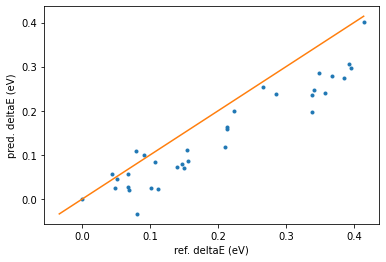

In [29]:
print_reordering_table(molecules_ref, molecules_pred, energies_ref, energies_pred);

We can see a significant improvement compared to the M3GNet-UP-2022 results! However, the results are not perfect.

## Generate conformers with the reference method and score with the retrained M3GNet model

As a second test, we can instead generate the conformers with the reference method and score them with the retrained m3gnet model.

This is quite expensive if the reference method is DFT!

[13.03|14:13:09] JOB generate_conformers_ref STARTED
[13.03|14:13:09] JOB generate_conformers_ref RUNNING
[13.03|14:13:54] JOB generate_conformers_ref FINISHED
[13.03|14:13:54] JOB generate_conformers_ref SUCCESSFUL
[13.03|14:13:54] JOB score_conformers_m3gnet_retrained STARTED
[13.03|14:13:54] JOB score_conformers_m3gnet_retrained RUNNING
[13.03|14:14:14] JOB score_conformers_m3gnet_retrained FINISHED
[13.03|14:14:14] JOB score_conformers_m3gnet_retrained SUCCESSFUL
Ref_i  Pred_i RMSD Ref_dE  Pred_dE
     0      1  0.0    0.00    0.00
     1      7  0.0    0.03    0.07
     2      6  0.0    0.05    0.05
     3      0  0.0    0.05   -0.00
     4      5  0.0    0.05    0.05
     5      3  0.0    0.05    0.02
     6      4  0.0    0.09    0.04
     7     12  0.0    0.10    0.09
     8     15  0.0    0.10    0.11
     9      9  0.0    0.11    0.08
    10     13  0.0    0.11    0.10
    11     11  0.0    0.11    0.09
    12     19  0.0    0.11    0.16
    13      8  0.0    0.12    0.07
   

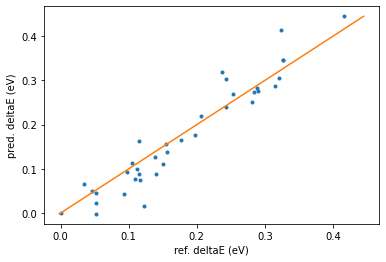

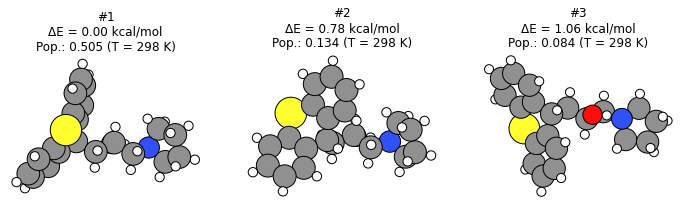

In [30]:
if perform_expensive_tests:
    generate_ref_job, molecules_ref, energies_ref, _, molecules_pred, energies_pred = (
        generate_and_score(
            starting_structure,
            gen_name="generate_conformers_ref",
            gen_settings=ref_s,
            score_name="score_conformers_m3gnet_retrained",
            score_settings=crest_al_job.results.get_production_engine_settings(),
        )
    )
    print_reordering_table(molecules_ref, molecules_pred, energies_ref, energies_pred)
    plot_conformers(generate_ref_job, 3)

## Compare the RMSD between the different conformer sets

The Conformer "Score" task performs single-point calculations.

If we instead change the task to "Optimize" we can see how similar the reference-method-optimized conformers are to the retrained-M3GNet-optimized conformers by comparing the RMSD.

The below is quite computationally expensive for a DFT reference engine.

[13.03|14:14:16] JOB opt_conformers_ref2 STARTED
[13.03|14:14:16] JOB opt_conformers_ref2 RUNNING
[13.03|14:14:37] JOB opt_conformers_ref2 FINISHED
[13.03|14:14:37] JOB opt_conformers_ref2 SUCCESSFUL
Ref_i  Pred_i RMSD Ref_dE  Pred_dE
     0      1  0.7    0.00    0.00
     1      6 rmsd > 0.7 ang.
     2      4  0.3    0.04    0.02
     3      8  0.1    0.05    0.06
     4      7  0.2    0.05    0.04
     5      0  0.2    0.07   -0.03
     6      9  0.2    0.07    0.06
     7     11 rmsd > 0.7 ang.
     8      2  0.1    0.07    0.02
     9     16  0.2    0.08    0.11
    10     15  0.3    0.09    0.10
    11      5  0.3    0.09    0.03
    12     10  0.3    0.14    0.07
    13     12  0.3    0.14    0.08
    14     17  0.2    0.15    0.11
    15     18 rmsd > 0.7 ang.
    16     20  0.2    0.19    0.16


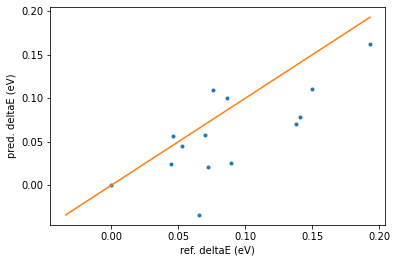

In [31]:
if perform_expensive_tests:
    opt_conformers_ref_job2 = ConformersJob(name="opt_conformers_ref2")
    opt_conformers_ref_job2.settings.input.ams.Task = "Optimize"
    opt_conformers_ref_job2.settings.input.ams.InputConformersSet = (
        generate_conformers_m3gnet_retrained_job.results.rkfpath()
    )
    opt_conformers_ref_job2.settings.input.ams.InputMaxEnergy = (
        5.0  # only conformers in the lowest 5.0 kcal/mol = 0.2 eV
    )
    opt_conformers_ref_job2.settings.input += ref_s.input
    opt_conformers_ref_job2.run()

    molecules_ref = opt_conformers_ref_job2.results.get_conformers()
    energies_ref = opt_conformers_ref_job2.results.get_relative_energies(unit="eV")
    molecules_pred = generate_conformers_m3gnet_retrained_job.results.get_conformers()
    energies_pred = generate_conformers_m3gnet_retrained_job.results.get_relative_energies(
        unit="eV"
    )
    print_reordering_table(molecules_ref, molecules_pred, energies_ref, energies_pred)

In the above table a few entries have "rmsd > 0.7 ang.". This means that the reference geometry optimization causes the structure to change significantly compared to the retrained-m3gnet-optimized geometry. 

In such cases it is not so meaningful to compare the relative energies between the reference and prediction, so those points are excluded from the table and from the plot.

## Custom active learning loop: add newly generated conformers to training set

The Simple Active Learning module in AMS only works for MD simulations, so it cannot automatically add optimized conformers to the training or validation sets.

However, you can do it yourself!

The Conformers "Score" function does not store or calculate the forces. So let's set up an AMS "Replay" job to recalculate the energies and forces to add to the training set:

In [32]:
replay_s = plams.Settings()
replay_s.input.ams.Task = "Replay"
replay_s.input.ams.Replay.File = generate_conformers_m3gnet_retrained_job.results.rkfpath()
replay_s.input.ams.Properties.Gradients = "Yes"
replay_s += ref_s
replay_job = plams.AMSJob(settings=replay_s, name="replay_new_conformers")
replay_job.run();

[13.03|14:14:37] JOB replay_new_conformers STARTED
[13.03|14:14:37] JOB replay_new_conformers RUNNING
[13.03|14:14:50] JOB replay_new_conformers FINISHED
[13.03|14:14:50] JOB replay_new_conformers SUCCESSFUL


Now import the data into a results importer:

In [33]:
ri = params.ResultsImporter.from_yaml(crest_al_job.results.get_reference_data_directory())
ri.add_trajectory_singlepoints(replay_job, properties=["energy", "forces"])
yaml_dir = "data_with_conformer_singlepoints_yaml"
ri.store(yaml_dir, backup=False)

['data_with_conformer_singlepoints_yaml/job_collection.yaml',
 'data_with_conformer_singlepoints_yaml/results_importer_settings.yaml',
 'data_with_conformer_singlepoints_yaml/training_set.yaml',
 'data_with_conformer_singlepoints_yaml/validation_set.yaml']

Then launch ParAMS:

In [34]:
params_job = params.ParAMSJob.from_yaml(yaml_dir, name="params_with_conformer_singlepoints")
params_job.settings.input += ml_s.input.ams
params_job.settings.input.MachineLearning.LoadModel = (
    crest_al_job.results.get_params_results_directory()
)
params_job.settings.input.Task = "MachineLearning"
params_job.settings.input.MachineLearning.LossCoeffs.Energy = 50
params_job.settings.input.MachineLearning.Target.Forces.Enabled = "No"
params_job.settings.input.MachineLearning.MaxEpochs = 100
params_job.run();

[13.03|14:14:52] JOB params_with_conformer_singlepoints STARTED
[13.03|14:14:52] JOB params_with_conformer_singlepoints RUNNING
[13.03|14:24:54] JOB params_with_conformer_singlepoints FINISHED
[13.03|14:24:54] JOB params_with_conformer_singlepoints SUCCESSFUL


If the job failed print the error message:

In [35]:
if not params_job.check():
    print(params_job.get_errormsg())

Generate conformers with the new model and score with the reference method:

In [36]:
_, molecules_pred, energies_pred, _, molecules_ref, energies_ref = generate_and_score(
    starting_structure,
    gen_name="generate_conformers_m3gnet_retrained_again",
    gen_settings=params_job.results.get_production_engine_settings(),
    score_name="score_conformers_ref2",
    score_settings=ref_s,
)

[13.03|14:24:54] JOB generate_conformers_m3gnet_retrained_again STARTED
[13.03|14:24:54] JOB generate_conformers_m3gnet_retrained_again RUNNING
[13.03|14:26:25] JOB generate_conformers_m3gnet_retrained_again FINISHED
[13.03|14:26:25] JOB generate_conformers_m3gnet_retrained_again SUCCESSFUL
[13.03|14:26:25] JOB score_conformers_ref2 STARTED
[13.03|14:26:25] Renaming job score_conformers_ref2 to score_conformers_ref2.002
[13.03|14:26:25] JOB score_conformers_ref2.002 RUNNING
[13.03|14:26:31] JOB score_conformers_ref2.002 FINISHED
[13.03|14:26:31] JOB score_conformers_ref2.002 SUCCESSFUL


And print/plot the results:

Ref_i  Pred_i RMSD Ref_dE  Pred_dE
     0      3  0.0    0.00    0.00
     1      1  0.0    0.00   -0.05
     2      4  0.0    0.00    0.01
     3      6  0.0    0.04    0.03
     4      5  0.0    0.05    0.02
     5      7  0.0    0.06    0.03
     6      9  0.0    0.06    0.06
     7      2  0.0    0.08   -0.04
     8      8  0.0    0.08    0.06
     9     11  0.0    0.10    0.07
    10      0  0.0    0.11   -0.05
    11     12  0.0    0.11    0.08
    12     10  0.0    0.14    0.07
    13     13  0.0    0.15    0.09
    14     17  0.0    0.16    0.16
    15     15  0.0    0.16    0.12
    16     14  0.0    0.17    0.12
    17     18  0.0    0.19    0.17
    18     16  0.0    0.20    0.16
    19     20  0.0    0.21    0.21
    20     22  0.0    0.21    0.22
    21     25  0.0    0.23    0.26
    22     19  0.0    0.24    0.21
    23     21  0.0    0.24    0.22
    24     23  0.0    0.25    0.24
    25     24  0.0    0.27    0.25
    26     26  0.0    0.29    0.27
    27     28  0.0  

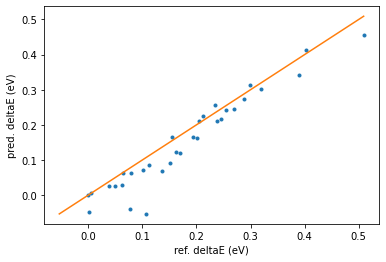

In [37]:
print_reordering_table(molecules_ref, molecules_pred, energies_ref, energies_pred);

Here we see even better agreement than before.

**Conclusion**: By manually adding retrained-ml-optimized conformers to the training set, you can improve the conformer prediction even more. This means to do your own "active learning" outside of the Simple Active Learning module in AMS.